# MyCobot Objects Gripping And Classification Tasks
## Import necessary libraries

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib as Path
import cv2
import json
import os
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

torch.__version__ 

'2.4.1'

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device

'mps'

## Load Dataset

In [3]:
torch.manual_seed(42)

def load_dataset(dataset_path):
    data = []
     # Loop through each action folder
    for action_folder in os.listdir(dataset_path):
        action_path = os.path.join(dataset_path, action_folder)
        
        # Check if it's a directory
        if os.path.isdir(action_path):
            # Paths to the image and joint_angles.json
            image_path = os.path.join(action_path, "image.png")
            json_path = os.path.join(action_path, "joint_angles.json")
            
            # Load image
            if os.path.exists(image_path):
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
                image = cv2.resize(image, dsize=(224, 224))
                image = image / 255.0 
                image = np.transpose(image, (2, 0, 1)) 
                image_tensor = torch.tensor(image, dtype=torch.float32)
            
            # Load joint angles
            if os.path.exists(json_path):
                with open(json_path, 'r') as f:
                    joint_angles = json.load(f)['actions']
                    joint_angles = [row[:-1] for row in joint_angles]
                    joint_angles_tensor = torch.tensor(joint_angles, dtype=torch.float32) / 180.0
            
            # Append to data list
            data.append((image_tensor, joint_angles_tensor))
    
    return data

Loaded 500 actions.
First Image Shape: torch.Size([3, 224, 224])
First Joint Angles: tensor([[ 0.0216, -0.0298, -0.3086, -0.0307, -0.0181,  0.4127],
        [ 0.0216, -0.2720, -0.3244,  0.2188, -0.0468,  0.4127],
        [ 0.0833, -0.0298, -0.3086, -0.1141, -0.0181,  0.3060],
        [ 0.2944, -0.2778,  0.0000, -0.0722, -0.0181,  0.3060],
        [ 0.0833,  0.0000,  0.0000,  0.0000,  0.0000,  0.3060]])


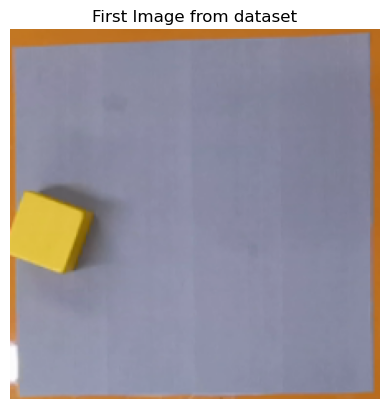

In [4]:
# Load the dataset
dataset_path = "dataset"
data = load_dataset(dataset_path)

# Print dataset information
print(f"Loaded {len(data)} actions.")
print(f"First Image Shape: {data[0][0].shape}")
print(f"First Joint Angles: {data[334][1]}")

# Display the first image
plt.imshow(data[334][0].permute(1, 2, 0))
plt.axis('off')
plt.title("First Image from dataset")
plt.show()

In [5]:
class ActionDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
# Create the dataset
dataset = ActionDataset(data)

## Data Split

Training Dataset Size: 400
Testing Dataset Size: 100
first image shape: torch.Size([3, 224, 224])
first joint angles: tensor([[ 0.1056, -0.0298, -0.3086, -0.0307, -0.0181,  0.5589],
        [ 0.1056, -0.2133, -0.4310,  0.2393, -0.0208,  0.5589],
        [ 0.0833, -0.0298, -0.3086, -0.1141, -0.0181,  0.3060],
        [-0.1167, -0.2500, -0.0586, -0.0585, -0.0181,  0.3893],
        [ 0.0833,  0.0000,  0.0000,  0.0000,  0.0000,  0.3060]])
train dataloader image shape: torch.Size([32, 3, 224, 224])
train dataloader image shape: torch.Size([32, 5, 6])


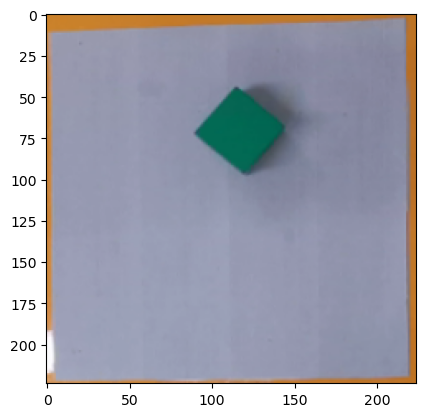

In [6]:
from torch.utils.data import random_split

# Define the split ratio (80% train, 20% test, for example)
train_ratio = 0.8
test_ratio = 0.2
total_size = len(dataset)
train_size = int(total_size * train_ratio)
test_size = total_size - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for the training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Testing Dataset Size: {len(test_dataset)}")
print(f"first image shape: {test_dataset[0][0].shape}")
print(f"first joint angles: {test_dataset[2][1]}")
plt.imshow(test_dataset[2][0].permute(1, 2, 0))
print(f"train dataloader image shape: {next(iter(train_dataloader))[0].shape}")
print(f"train dataloader image shape: {next(iter(train_dataloader))[1].shape}")

## Create model class

In [7]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Define the model class
class ImageToJointAngles(nn.Module):
    def __init__(self):
        super(ImageToJointAngles, self).__init__()
        # Backbone: Use a pretrained ResNet18 for feature extraction
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()  # Remove the final fully connected layer
        
        # Fully connected layers to predict joint angles
        self.fc = nn.Sequential(
            nn.Linear(512, 256),  # ResNet18 outputs 512 features
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 30)  # 5x6 = 30 joint angles
        )
        
    def forward(self, x):
        # Feature extraction
        features = self.resnet(x)
        
        # Fully connected layers
        joint_angles = self.fc(features)
        
        # Reshape output to (batch_size, 5, 6)
        joint_angles = joint_angles.view(-1, 5, 6)
        
        return joint_angles


In [8]:
torch.manual_seed(42)
model_0 = ImageToJointAngles().to(device)
x = torch.randn(32, 3, 224, 224)  # Batch of 32 images
output = model_0(x.to(device))

print("Output shape:", output.shape)

Output shape: torch.Size([32, 5, 6])


## Pick up the loss function and optimizer

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

## Training and Testing Loop

In [10]:
num_epochs = 7

for epoch in range(num_epochs):
    running_loss = 0.0

    for batch_idx, (images, targets) in enumerate(train_dataloader):
        images, targets = images.to(device), targets.to(device)

        # Forward Pass
        outputs = model_0(images)
        loss = loss_fn(outputs, targets)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print progress for every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Average loss per epoch
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}")

    # Test the model
    model_0.eval()
    with torch.no_grad():
        test_loss = 0.0
        for images, targets in test_dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model_0(images)
            loss = loss_fn(outputs, targets)
            test_loss += loss.item()

        test_loss /= len(test_dataloader)
        print(f"Test Loss: {test_loss:.4f}")


Epoch [1/7], Step [10/13], Loss: 0.0151
Epoch [1/7] Average Loss: 1.1767
Test Loss: 65.4884
Epoch [2/7], Step [10/13], Loss: 0.1660
Epoch [2/7] Average Loss: 48.0288
Test Loss: 0.0744
Epoch [3/7], Step [10/13], Loss: 0.0097
Epoch [3/7] Average Loss: 0.0299
Test Loss: 0.0097
Epoch [4/7], Step [10/13], Loss: 0.0083
Epoch [4/7] Average Loss: 0.0086
Test Loss: 0.0085
Epoch [5/7], Step [10/13], Loss: 0.0071
Epoch [5/7] Average Loss: 0.0081
Test Loss: 0.0085
Epoch [6/7], Step [10/13], Loss: 0.0080
Epoch [6/7] Average Loss: 0.0080
Test Loss: 0.0083
Epoch [7/7], Step [10/13], Loss: 0.0086
Epoch [7/7] Average Loss: 0.0081
Test Loss: 0.0084


Loss: 0.0047
Target Joint Angles: [[ 26.  -5. -56.  -6.  -3.  28.]
 [ 26. -54. -46.  27. -10.  28.]
 [ 15.  -5. -56. -21.  -3.  55.]
 [ 53. -50.   0. -13.  -3.  55.]
 [ 15.   0.   0.   0.   0.  55.]]
Predicted Joint Angles: [[ 18.  -4. -54.  -4.  -3.  58.]
 [ 18. -50. -47.  33.  -5.  58.]
 [ 16.  -7. -54. -20.  -4.  54.]
 [ 20. -25. -30. -15.  -2.  54.]
 [ 16.   0.   1.   1.   0.  54.]]


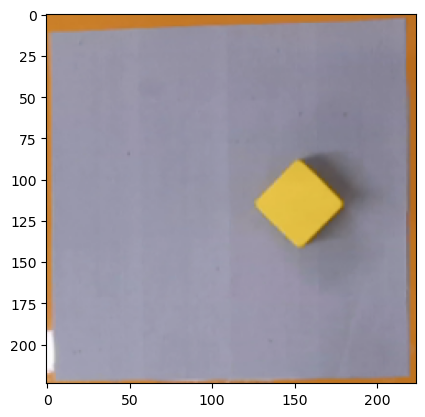

In [11]:
# Test the model with the first sample from the test dataset
model_0.eval()
with torch.no_grad():
    image, target = train_dataset[399]
    image = image.unsqueeze(0).to(device)
    target = target.unsqueeze(0).to(device)
    output = model_0(image)
    loss = loss_fn(output, target)
    print(f"Loss: {loss.item():.4f}")

    # Convert to numpy arrays
    target = target.cpu().numpy().flatten()
    output = output.cpu().numpy().flatten()

    # Convert to matrix (5x6)

    target = np.round(target.reshape(5, 6) * 180.0)  # Convert to degrees
    output = np.round(output.reshape(5, 6) * 180.0)  # Convert to degrees

    # Print the target and predicted joint angles
    print("Target Joint Angles:", target)
    print("Predicted Joint Angles:", output)

plt.imshow(image.cpu().squeeze(0).permute(1, 2, 0))